# Brain Tumor Segmentation (2D UNet)

This notebook implements semantic segmentation of brain tumors from multi-modal MRI scans using a 2D UNet architecture. It was developed as part of my BSc AI coursework and runs fully in Google Colab.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats2020-training-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brats2020-training-data


In [ ]:
!pip install segmentation-models-pytorch albumentations

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np
import albumentations as A

class BraTSDatasetH5(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.h5')]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with h5py.File(self.files[idx], 'r') as f:
            image = f['image'][:]  # (H, W, 4)
            mask = f['mask'][:]    # (H, W, 3)

        # Move channels first
        image = np.transpose(image, (2, 0, 1))  # (4, H, W)
        mask = np.transpose(mask, (2, 0, 1))    # (3, H, W)

        # Normalize each channel
        image = (image - image.mean(axis=(1,2), keepdims=True)) / (image.std(axis=(1,2), keepdims=True) + 1e-8)

        # Convert one-hot mask to class indices
        mask = mask.argmax(axis=0).astype(np.int64)  # (H, W)

        # Albumentations expects (H, W, C)
        image = np.transpose(image, (1, 2, 0)).astype(np.float32)  # (H, W, 4)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Back to torch tensors
        image = torch.from_numpy(np.transpose(image, (2, 0, 1))).float()  # (4, H, W)
        mask = torch.from_numpy(mask).long()  # (H, W)

        return image, mask

In [ ]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    # A.Resize(128, 128),  # Uncomment if you want to resize
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
from torch.utils.data import DataLoader, random_split

data_path = os.path.join(path, "BraTS2020_training_data/content/data")

dataset = BraTSDatasetH5(
    root_dir=data_path,
    transform=transform
)

val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=20, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=20, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import segmentation_models_pytorch as smp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.Unet(
    encoder_name="resnet34",        # Pretrained encoder
    encoder_weights="imagenet",     # Use ImageNet weights
    in_channels=4,                  # 4 MRI modalities
    classes=3,                      # Number of segmentation classes
)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        logits = F.softmax(logits, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
        dims = (0, 2, 3)
        intersection = torch.sum(logits * targets_one_hot, dims)
        union = torch.sum(logits + targets_one_hot, dims)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=1)
        probs = torch.exp(log_probs)
        targets_one_hot = F.one_hot(targets, logits.shape[1]).permute(0, 3, 1, 2).float()
        ce_loss = -targets_one_hot * log_probs
        if self.alpha is not None:
            ce_loss = self.alpha * ce_loss
        focal_loss = (1 - probs) ** self.gamma * ce_loss
        return focal_loss.sum(dim=1).mean()

class HybridLoss(nn.Module):
    def __init__(self, dice_weight=1.0, focal_weight=1.0, gamma=2.0):
        super().__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(gamma=gamma)
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        return self.dice_weight * self.dice(logits, targets) + self.focal_weight * self.focal(logits, targets)

In [ ]:
for images, masks in train_loader:
    print(images.shape)  # [batch, 4, H, W]
    print(masks.shape)   # [batch, H, W]
    outputs = model(images.to(device))
    print(outputs.shape) # [batch, 3, H, W]
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([128, 4, 240, 240])
torch.Size([128, 240, 240])
torch.Size([128, 3, 240, 240])


In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
import numpy as np

def dice_score(preds, targets, num_classes=3, smooth=1e-5):
    # preds, targets: (B, H, W)
    dice = 0
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice += (2. * intersection + smooth) / (union + smooth)
    return dice / num_classes

def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    dice_scores = []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            dice = dice_score(preds, masks)
            dice_scores.append(dice.item())
    return running_loss / len(dataloader.dataset), np.mean(dice_scores)

In [ ]:
import torch.optim as optim

def run_training(
    model, train_loader, val_loader, device,
    lr=1e-4, num_epochs=50, patience=10,
    dice_weight=1.0, focal_weight=1.0, gamma=2.0
):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = HybridLoss(dice_weight=dice_weight, focal_weight=focal_weight, gamma=gamma)
    scaler = GradScaler()
    best_val_dice = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'val_dice': []}

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        val_loss, val_dice = validate(model, val_loader, criterion, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Dice={val_dice:.4f}")

        # Checkpointing
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved new best model!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break
    return history, best_val_dice

In [ ]:
# Example grid search for learning rate and loss weights
lrs = [1e-4, 5e-4]
dice_weights = [1.0]
focal_weights = [0.5, 1.0]
gammas = [2.0]

best_score = 0
best_params = None

for lr in lrs:
    for dw in dice_weights:
        for fw in focal_weights:
            for gamma in gammas:
                print(f"\nTraining with lr={lr}, dice_weight={dw}, focal_weight={fw}, gamma={gamma}")
                # Re-instantiate model for each run
                model = smp.Unet(
                    encoder_name="resnet34",
                    encoder_weights="imagenet",
                    in_channels=4,
                    classes=3,
                ).to(device)
                history, val_dice = run_training(
                    model, train_loader, val_loader, device,
                    lr=lr, num_epochs=30, patience=5,
                    dice_weight=dw, focal_weight=fw, gamma=gamma
                )
                if val_dice > best_score:
                    best_score = val_dice
                    best_params = (lr, dw, fw, gamma)
                print(f"Validation Dice: {val_dice:.4f}")

print(f"\nBest Val Dice: {best_score:.4f} with params: lr={best_params[0]}, dice_weight={best_params[1]}, focal_weight={best_params[2]}, gamma={best_params[3]}")


Training with lr=0.0001, dice_weight=1.0, focal_weight=0.5, gamma=2.0


<ipython-input-10-6e1a20ddd1e5>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-9-099cc110b0ca>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss=0.5218, Val Loss=0.3147, Val Dice=0.7541
Saved new best model!
Epoch 2: Train Loss=0.2577, Val Loss=0.2383, Val Dice=0.7875
Saved new best model!
Epoch 3: Train Loss=0.2236, Val Loss=0.2161, Val Dice=0.8035
Saved new best model!
Epoch 4: Train Loss=0.2087, Val Loss=0.2094, Val Dice=0.8078
Saved new best model!
Epoch 5: Train Loss=0.2018, Val Loss=0.2007, Val Dice=0.8153
Saved new best model!
Epoch 6: Train Loss=0.1989, Val Loss=0.1989, Val Dice=0.8167
Saved new best model!
Epoch 7: Train Loss=0.1926, Val Loss=0.1986, Val Dice=0.8172
Saved new best model!
Epoch 8: Train Loss=0.1881, Val Loss=0.1901, Val Dice=0.8245
Saved new best model!
Epoch 9: Train Loss=0.1882, Val Loss=0.2006, Val Dice=0.8143
Epoch 10: Train Loss=0.1837, Val Loss=0.1869, Val Dice=0.8270
Saved new best model!
Epoch 11: Train Loss=0.1859, Val Loss=0.1797, Val Dice=0.8339
Saved new best model!
Epoch 12: Train Loss=0.1819, Val Loss=0.1883, Val Dice=0.8259
Epoch 13: Train Loss=0.1793, Val Loss=0.1780,

In [ ]:
from google.colab import files

files.download("best_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Get the best parameters from your grid search results
best_lr, best_dice_weight, best_focal_weight, best_gamma = best_params  # These were saved in best_params tuple

# Define criterion with the best hyperparameters
criterion = HybridLoss(
    dice_weight=best_dice_weight,    # This was 1.0 in your grid
    focal_weight=best_focal_weight,  # This was either 0.5 or 1.0
    gamma=best_gamma                 # This was 2.0
)

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Now you can run validation
val_loss, val_dice = validate(model, val_loader, criterion, device)
print(f"Final Val Loss: {val_loss:.4f}, Final Val Dice: {val_dice:.4f}")

Final Val Loss: 0.1762, Final Val Dice: 0.8441


In [ ]:
best_params

(0.0001, 1.0, 1.0, 2.0)

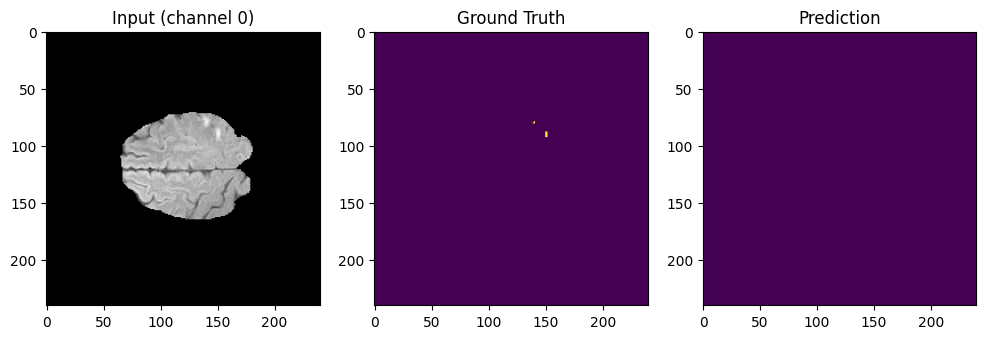

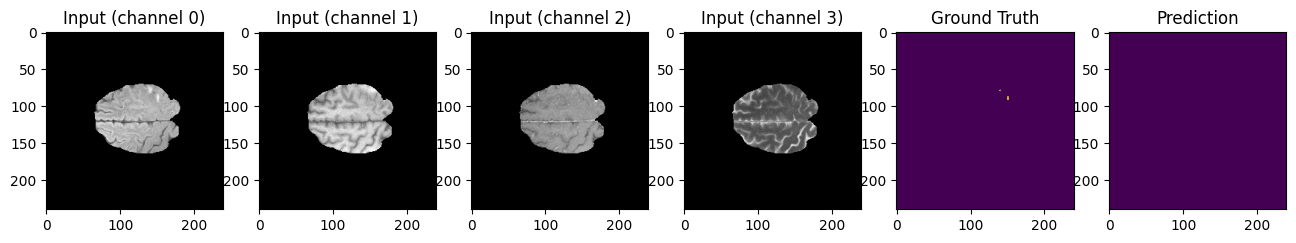

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        # Check if this batch contains any images with tumors
        # Sum the mask values - if > 0, there's a tumor
        has_tumor = masks.sum(dim=(1,2)) > 0

        if has_tumor.any():
            # Get the first image with a tumor in this batch
            tumor_idx = has_tumor.nonzero()[0][0]

            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()

            plt.figure(figsize=(12,4))

            plt.subplot(1,3,1)
            plt.imshow(images[tumor_idx,0].cpu(), cmap='gray')  # Showing first channel
            plt.title('Input (channel 0)')

            plt.subplot(1,3,2)
            plt.imshow(masks[tumor_idx].cpu())
            plt.title('Ground Truth')

            plt.subplot(1,3,3)
            plt.imshow(preds[tumor_idx])
            plt.title('Prediction')

            plt.show()
            break

# Optional: To see all 4 input channels for better analysis
plt.figure(figsize=(16,4))
for ch in range(4):
    plt.subplot(1,6,ch+1)
    plt.imshow(images[tumor_idx,ch].cpu(), cmap='gray')
    plt.title(f'Input (channel {ch})')

plt.subplot(1,6,5)
plt.imshow(masks[tumor_idx].cpu())
plt.title('Ground Truth')

plt.subplot(1,6,6)
plt.imshow(preds[tumor_idx])
plt.title('Prediction')
plt.show()

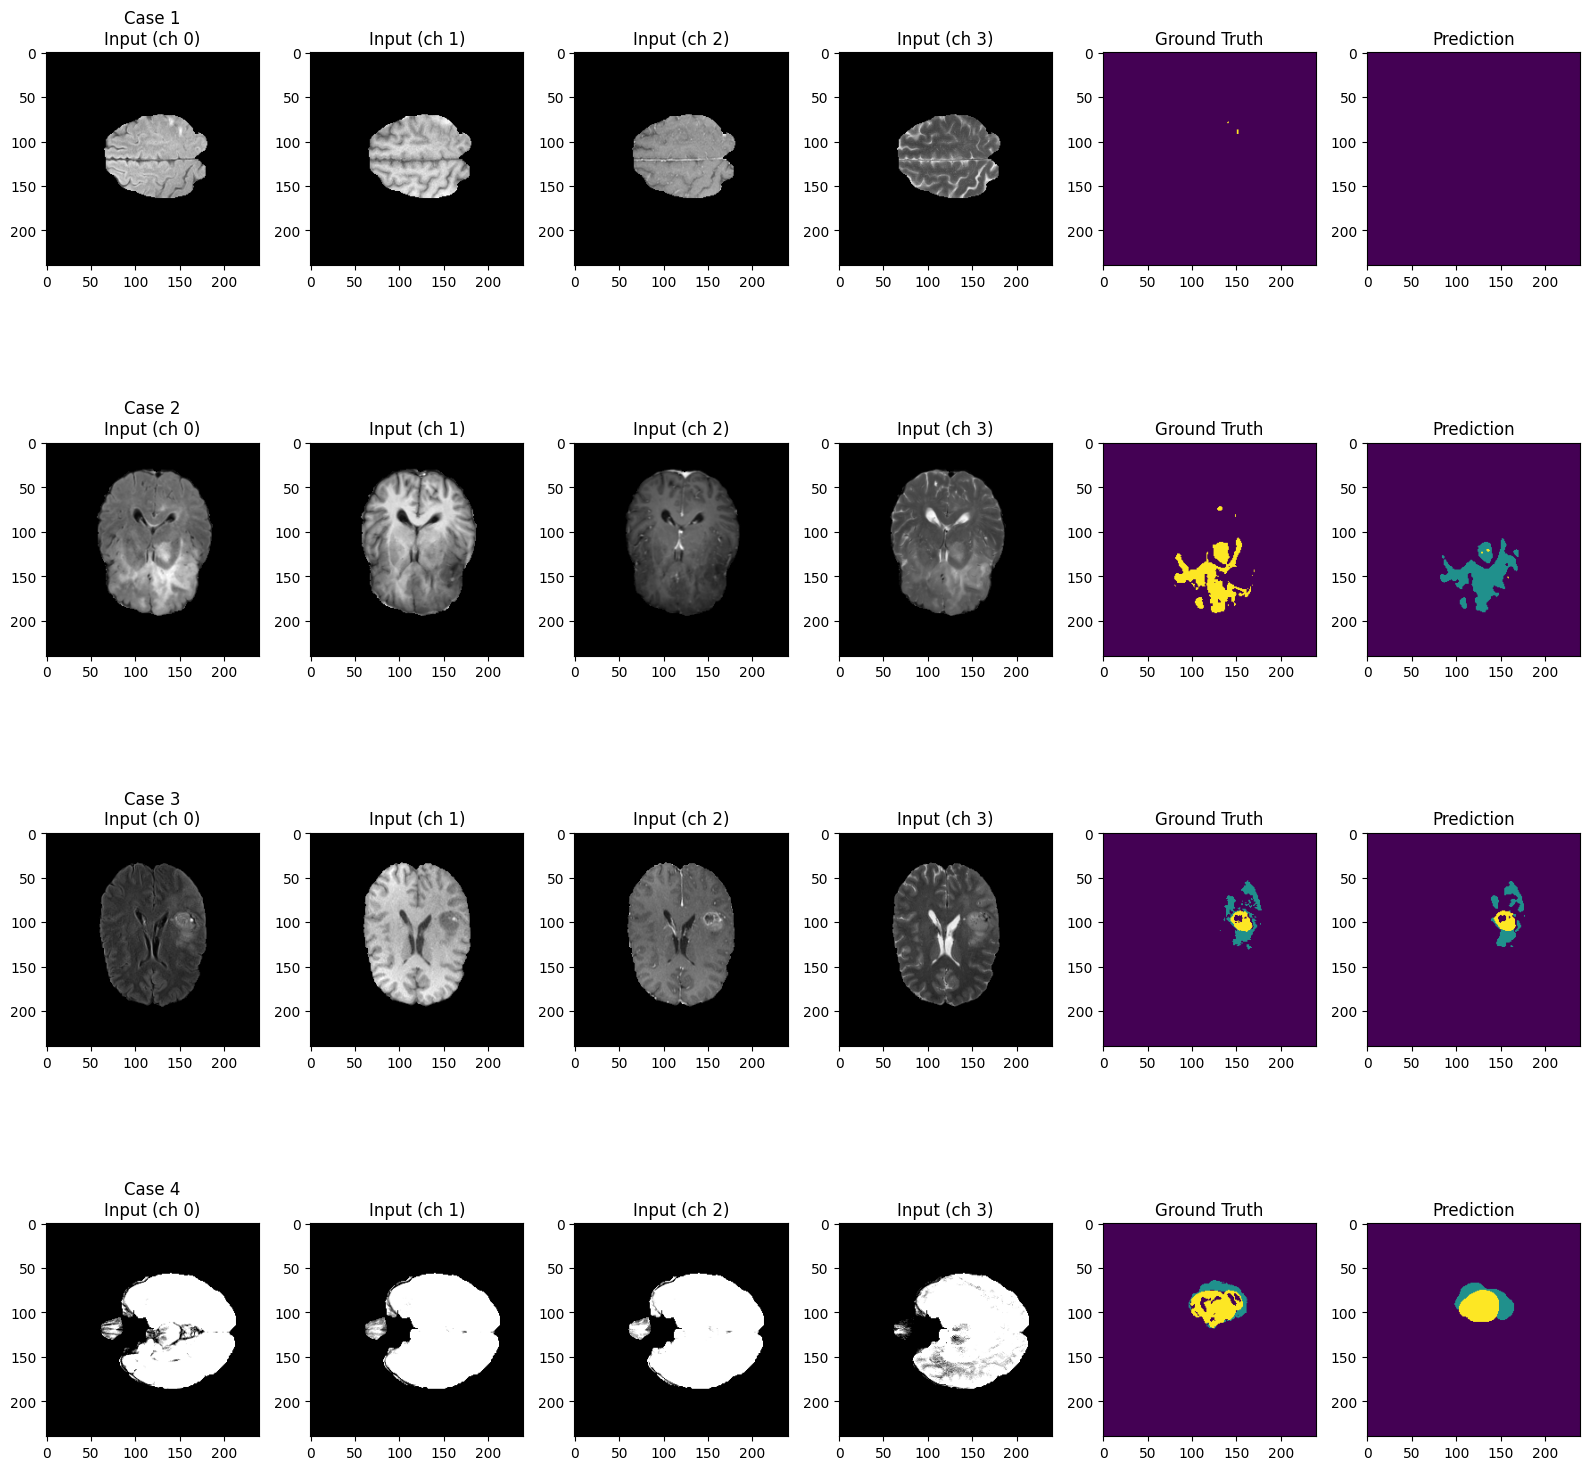

In [ ]:
model.eval()
with torch.no_grad():
    num_cases_to_show = 4  # You can adjust this number
    cases_found = 0

    plt.figure(figsize=(16, 4*num_cases_to_show))

    for images, masks in val_loader:
        # Find images with tumors in this batch
        has_tumor = masks.sum(dim=(1,2)) > 0
        tumor_indices = has_tumor.nonzero().squeeze()

        if len(tumor_indices.shape) == 0 and has_tumor.any():  # Single index case
            tumor_indices = tumor_indices.unsqueeze(0)

        for idx in tumor_indices:
            if cases_found >= num_cases_to_show:
                break

            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()

            # Plot row for this case
            # Input
            plt.subplot(num_cases_to_show, 6, cases_found*6 + 1)
            plt.imshow(images[idx,0].cpu(), cmap='gray')
            plt.title(f'Case {cases_found+1}\nInput (ch 0)')

            # Other channels
            for ch in range(1,4):
                plt.subplot(num_cases_to_show, 6, cases_found*6 + ch + 1)
                plt.imshow(images[idx,ch].cpu(), cmap='gray')
                plt.title(f'Input (ch {ch})')

            # Ground Truth
            plt.subplot(num_cases_to_show, 6, cases_found*6 + 5)
            plt.imshow(masks[idx].cpu())
            plt.title('Ground Truth')

            # Prediction
            plt.subplot(num_cases_to_show, 6, cases_found*6 + 6)
            plt.imshow(preds[idx])
            plt.title('Prediction')

            cases_found += 1

        if cases_found >= num_cases_to_show:
            break

    plt.tight_layout()
    plt.show()